In [1]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
from pathlib import Path
import os

dataset_name = 'M_SuicidalIdeation_rsfMRI.GS'
train_out = Path(os.getcwd()+'/data_1106/'+dataset_name+'_train.csv')
test_out =Path(os.getcwd()+'/data_1106/'+dataset_name+'_test.csv')


train_data= pd.read_csv(train_out)
test_data= pd.read_csv(test_out)
target ='Suicidalideation.x'
unused_feat = ['Set', 'subjectkey', 'abcd_site', 'Unnamed: 0', 'kflod',
               'src_subject_id','interview_date','gender','eventname',
               'rsfmri_cor_network.gordon_subcort.aseg_visitid', 'X']
n=0
start_mri = 0;
for i in test_data.columns:
    #print(i)
    if i =='rsfmri_cor_network.gordon_subcort.aseg_visitid':
        start_mri =n
    n +=1

    
mri = list(test_data.columns[start_mri:])
#print(mri)
Num_FOLDS  = 3
# the number of feature that you want to show 
Num_feat = 20

In [5]:
# na 에 0을 채우고 index reset
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
# Store maximum auc

test_data_processed= test_data.fillna(0).reset_index(drop=True)
train_data_processed = train_data.fillna(0).reset_index(drop=True)


features = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 

if "Set" not in train_data_processed.columns:
    train_data_processed["Set"] = np.random.choice(["train", "valid"] , p =[.75, .25], size=(train_data_processed.shape[0],))

train_indices = train_data_processed[train_data_processed.Set=="train"].index
valid_indices = train_data_processed[train_data_processed.Set=="valid"].index


X_train = train_data_processed[features].values[train_indices]
y_train = train_data_processed[target].values[train_indices]
X_valid = train_data_processed[features].values[valid_indices]
y_valid = train_data_processed[target].values[valid_indices]
X_test = test_data_processed[features].values
y_test = test_data_processed[target].values

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ",y_train.shape)
print("X_valid.shape: ", X_valid.shape)
print("y_valid.shape: ",y_valid.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ",y_test.shape)

n_ = [4,8,16]
lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
w_ = [0.01, 0.001, 0.0001]
g_ = [0.95, 0.99, 0.9]
ss_ = [10, 20, 30]
all_ = [n_, lr_, w_, g_, ss_]
h_space = [s for s in itertools.product(*all_)]

hy = h_space[0]
clf = TabNetClassifier(n_a = hy[0],
                       n_d = hy[0],
                       optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                       scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=0
                           )
clf.fit(X_train, y_train, X_valid, y_valid, patience=10, batch_size=256, max_epochs=200)
preds_acc = clf.predict(X_test)
preds_prob = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
test_acc = accuracy_score(preds_acc, y_test)
print("Best hy:", hy)
print("FINAL TEST SCORE", test_auc, test_acc)
importance =clf.feature_importances_


X_train.shape:  (4835, 523)
y_train.shape:  (4835,)
X_valid.shape:  (1635, 523)
y_valid.shape:  (1635,)
X_test.shape:  (372, 523)
y_test.shape:  (372,)
Device used : cuda
Best hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE 0.7414635556712058 0.5080645161290323


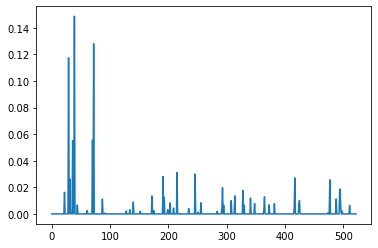

In [12]:
importance =clf.feature_importances_
plt.plot(importance)

labels_importance=importance.argsort()[::-1]

importance_sort = np.sort(importance)[::-1]

feat_name_sort=test_data_processed[features].columns[labels_importance]
important_features = pd.DataFrame() 


for i in range (20):
    feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['Feature', 'importance'])
    important_features=pd.concat([important_features,feature])

important_features=important_features.reset_index(drop=True)

In [13]:
important_features

,Feature,importance
0,TotProb.CBCL,0.148641
1,PPSP_frequency,0.127897
2,AnxDep.CBCL,0.117325
3,totalBIS,0.055421
4,Aggressive.CBCL,0.055208
5,rsfmri_cor_network.gordon_smmouth_network.gordon_default,0.031101
6,rsfmri_cor_network.gordon_ventralattn_network.gordon_smhand,0.030022
7,rsfmri_cor_network.gordon_retrosplenialtemporal_network.gordon_frontoparietal,0.028078
8,rsfmri_cor_network.gordon_retrosplenialtemporal_subcort.aseg_accumbens.area.lh,0.027111
9,Somatic.CBCL,0.026495


In [118]:
import seaborn as sns
feature = ["M+P", "Pheno", "MRI"]
def show_feature_importance(feature_importance_df, name, feature):
    cols = (feature_importance_df[["Feature", "Importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="Importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="Importance", y="Feature", data=best_features.sort_values(by="Importance", ascending=False))
    plt.title(f'{name}' )
    plt.tight_layout()
    plt.savefig(f'feature_importance_{name}_{feature}.png')
    


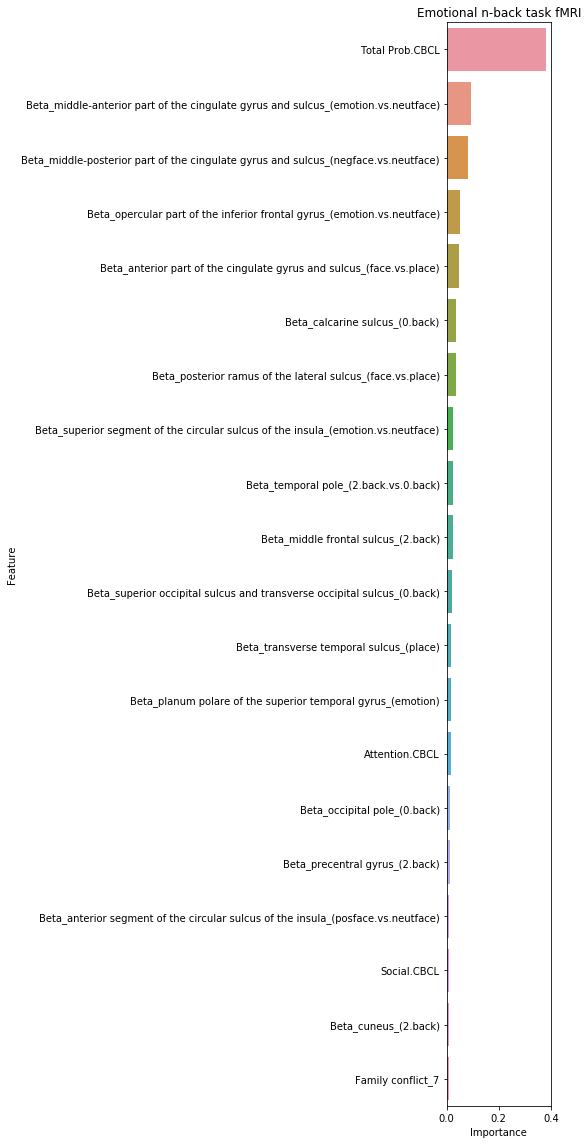

In [119]:

full_name = "enbackfMRI"
name = "Emotional n-back task fMRI"

path = Path(os.getcwd()+'/tabnet_FP_best model_'+full_name+'.csv')

data = pd.read_csv(path)

show_feature_importance(data, name, feature[0])


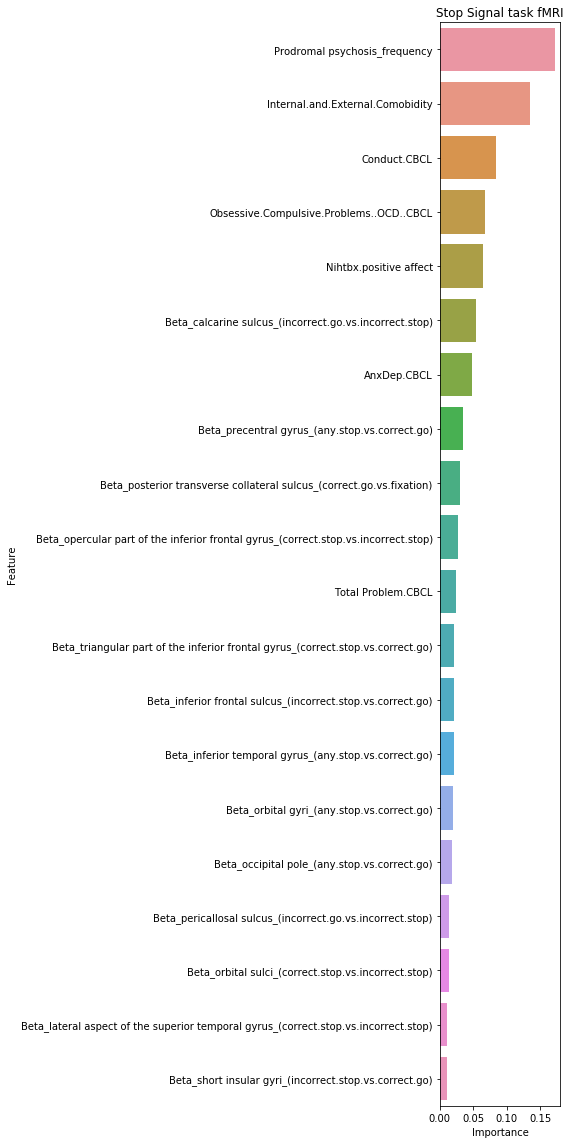

In [122]:

full_name = "sstfMRI"
name ="Stop Signal task fMRI"
path = Path(os.getcwd()+'/tabnet_FP_best model_'+full_name+'.csv')

data = pd.read_csv(path)

show_feature_importance(data, name, feature[0])


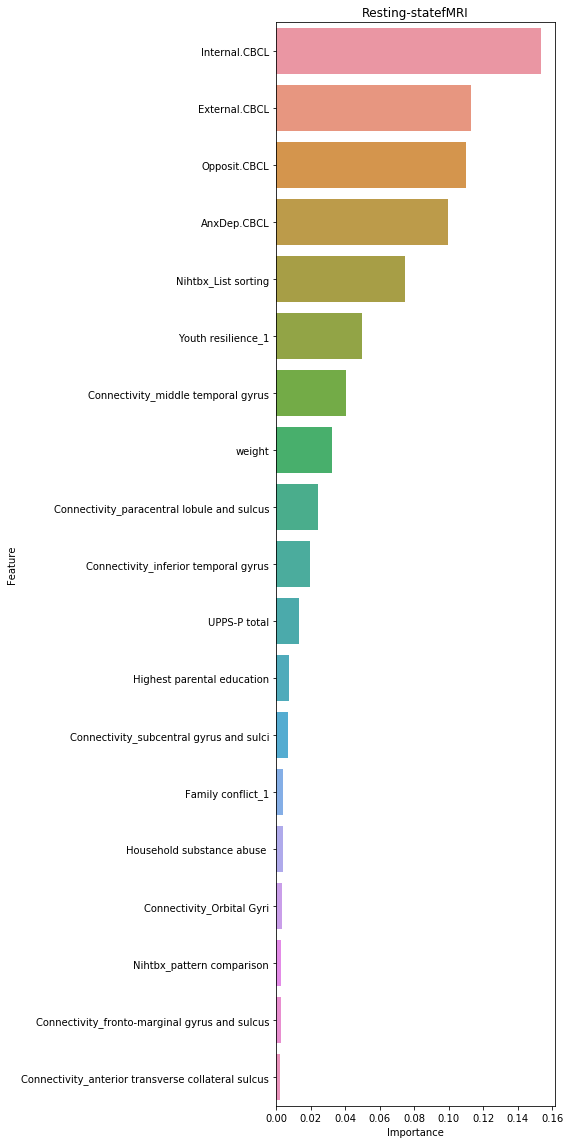

In [125]:

full_name = "rsfMRI"
path = Path(os.getcwd()+'/tabnet_FP_best model_'+full_name+'.csv')
name = "Resting-statefMRI"

data = pd.read_csv(path)
data.columns =["Feature", "Importance"]
show_feature_importance(data, name, feature[0])


In [109]:
data

,Feature,Importance
0,Total Prob.CBCL,0.381279
1,Beta_middle-anterior part of the cingulate gyrus and sulcus_(emotion.vs.neutface),0.094628
2,Beta_middle-posterior part of the cingulate gyrus and sulcus_(negface.vs.neutface),0.080070
3,Beta_opercular part of the inferior frontal gyrus_(emotion.vs.neutface),0.050218
4,Beta_anterior part of the cingulate gyrus and sulcus_(face.vs.place),0.046243
5,Beta_calcarine sulcus_(0.back),0.035876
6,Beta_posterior ramus of the lateral sulcus_(face.vs.place),0.034826
7,Beta_superior segment of the circular sulcus of the insula_(emotion.vs.neutface),0.023718
8,Beta_temporal pole_(2.back.vs.0.back),0.023644
9,Beta_middle frontal sulcus_(2.back),0.022442


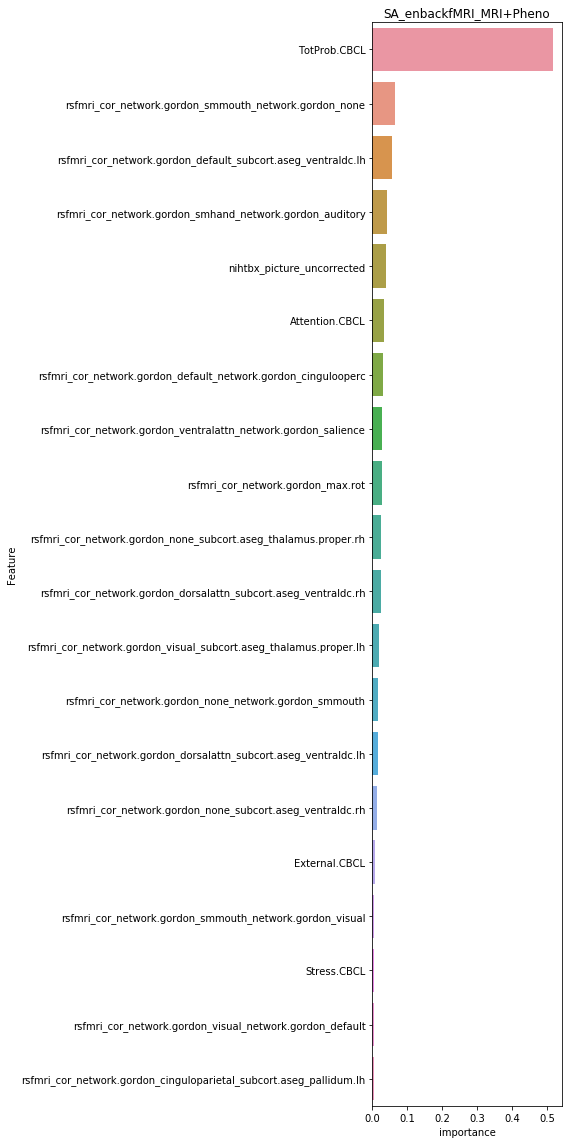

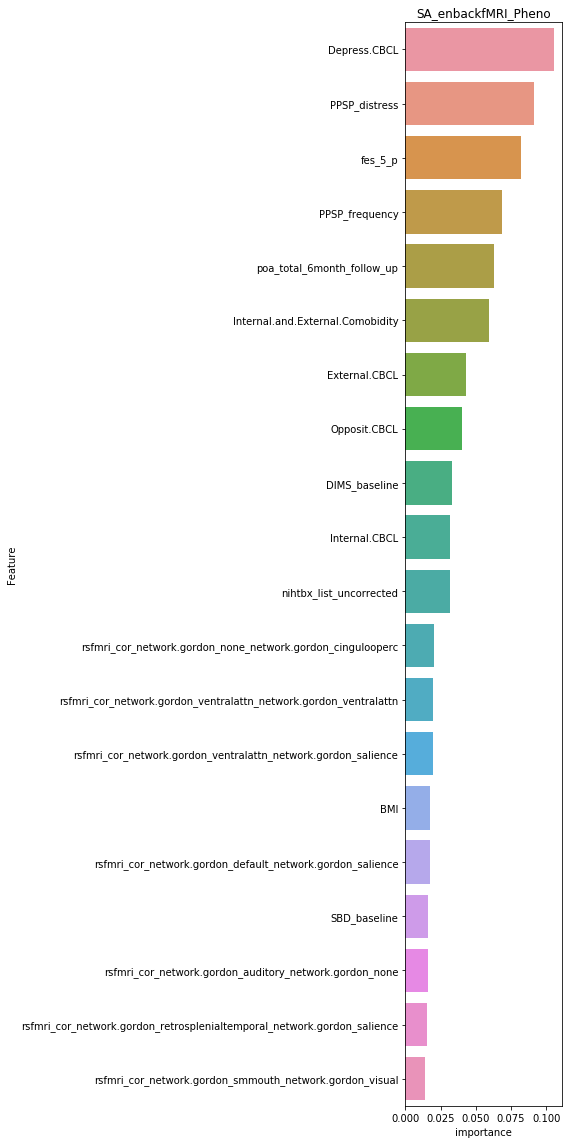

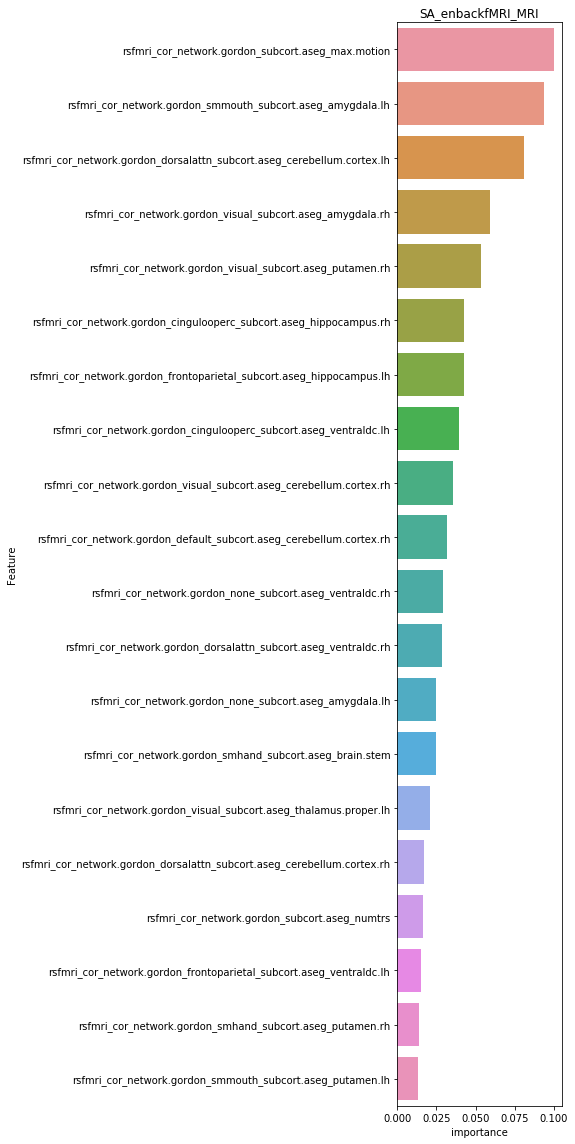

In [105]:

full_name = "IdeationNAttempt_enbackfMRI"
path = Path(os.getcwd()+'/Summary Prediction_new - '+dataset_name+'_3ROCcurves.png')
simple_name = "SA_enbackfMRI"
data = pd.read_csv(path)
dataall = []
j=1
for i in range (3):
    data_part = data.iloc[:,j:j+2]
    dataall.append(data_part)
    j+=2 
for i in range(3):
    dataall[i].columns=["Feature", "importance"]
    show_feature_importance(dataall[i], simple_name, feature[i])


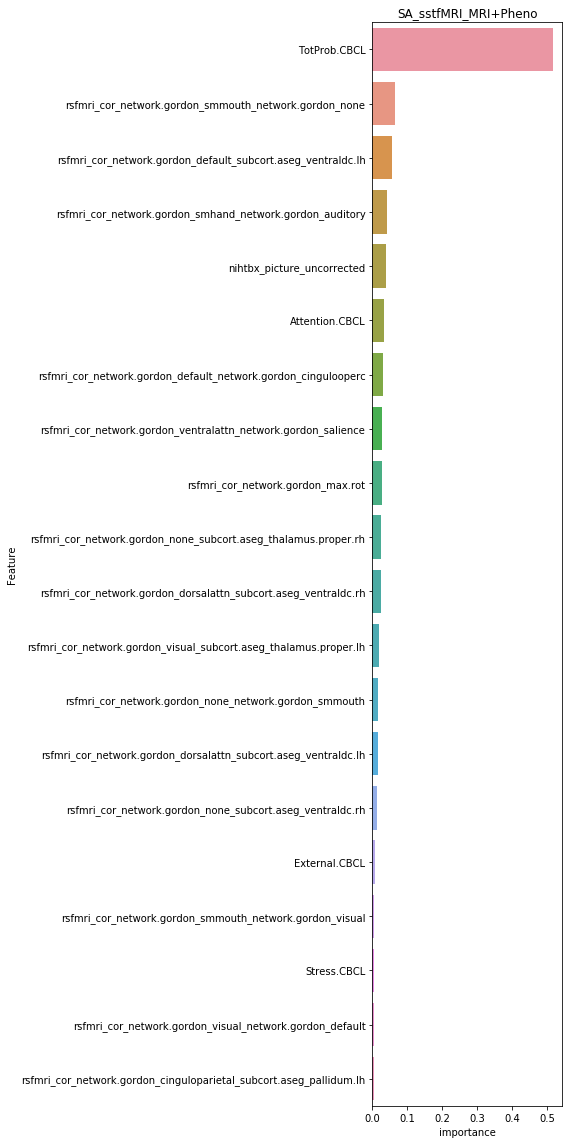

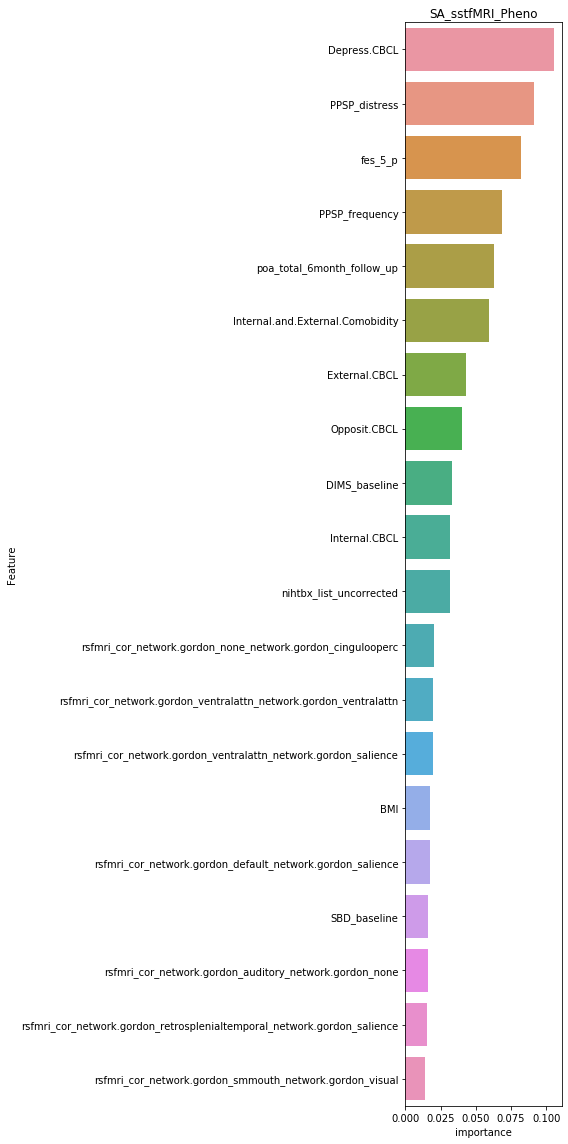

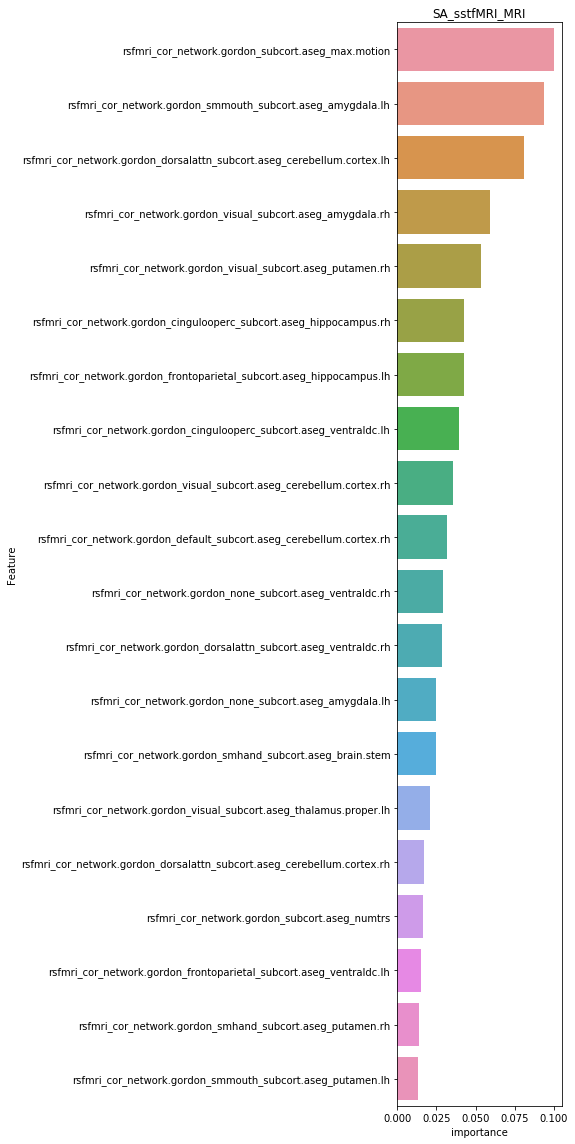

In [103]:

full_name = "M_IdeationNAttempt_sstfMRI"
path = Path(os.getcwd()+'/Summary Prediction_new - '+dataset_name+'_3ROCcurves.png')
simple_name = "SA_sstfMRI"
data = pd.read_csv(path)
dataall = []
j=1
for i in range (3):
    data_part = data.iloc[:,j:j+2]
    dataall.append(data_part)
    j+=2 
for i in range(3):
    dataall[i].columns=["Feature", "importance"]
    show_feature_importance(dataall[i], simple_name, feature[i])


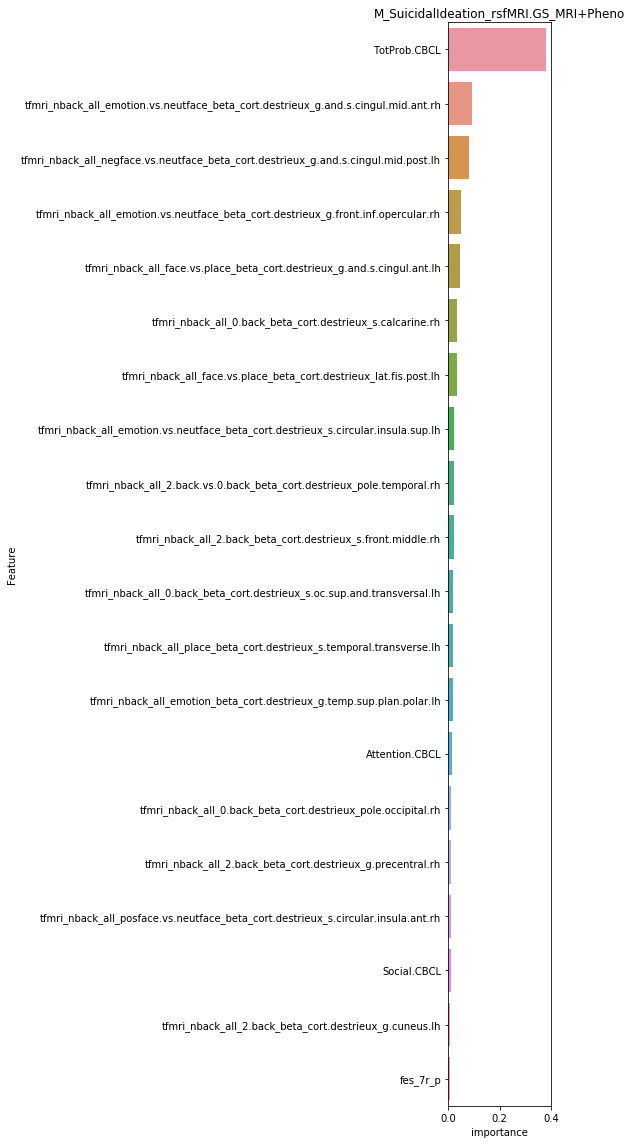

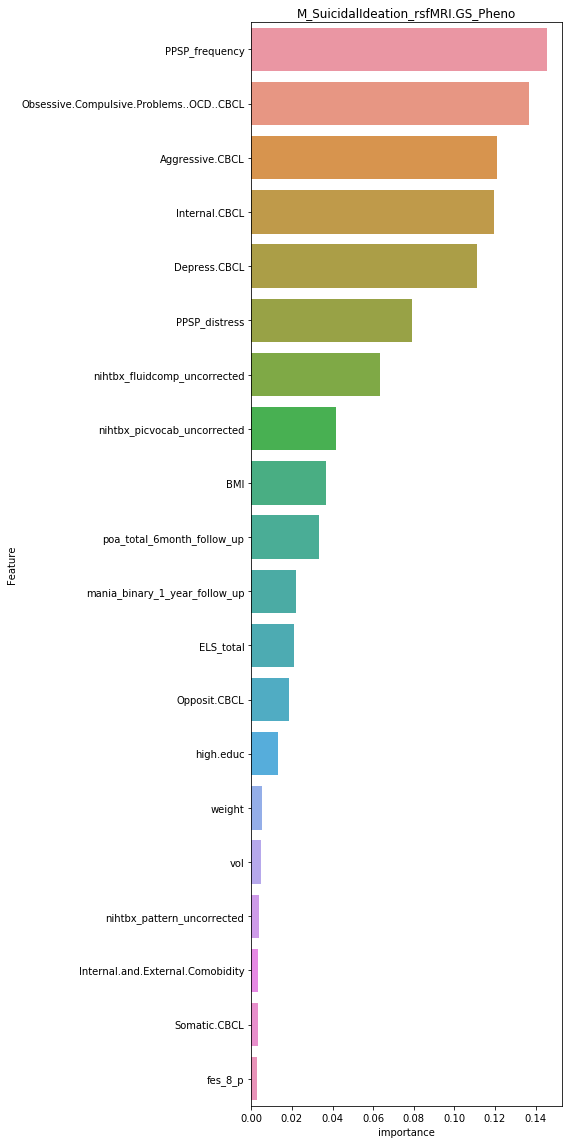

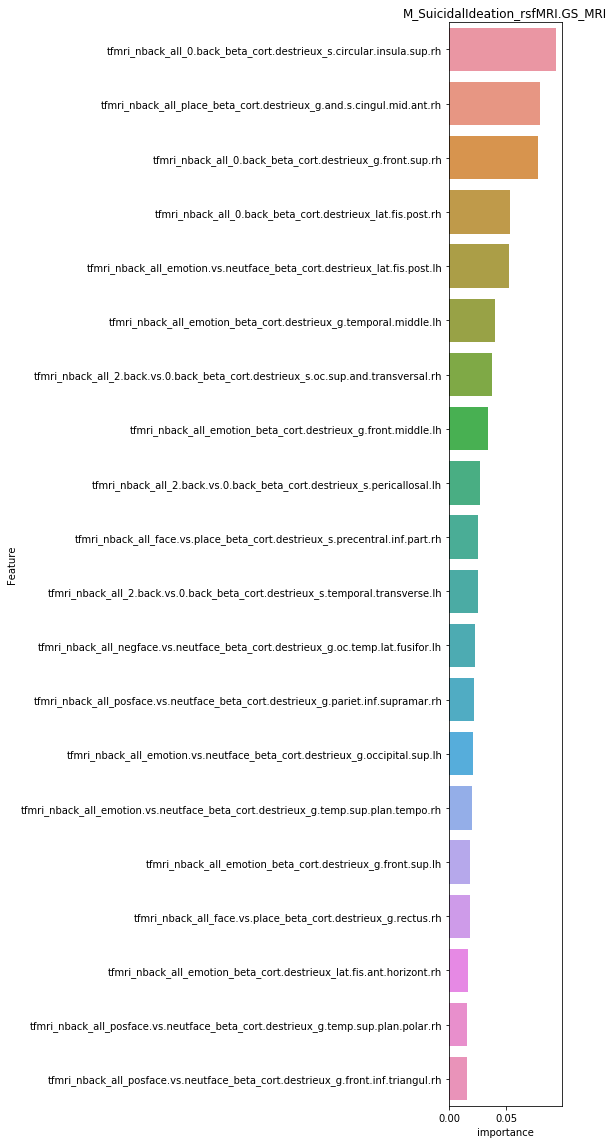

In [ ]:
import seaborn as sns
feature = "MRI+Pheno"
simple_name = "SI_rsFMRI.GS"
def show_feature_importance(feature_importance_df, name, feature):
    cols = (feature_importance_df[["feature name", "ratio"]]
            .groupby("feature name")
            .mean()
            .sort_values(by="ratio", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.feature.name.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="ratio", ascending=False))
    plt.title(f'{name}_{feature}' )
    plt.tight_layout()
    #plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')
    
show_feature_importance(data.iloc[:,1:3], simple_name, feature)



In [12]:
train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
features_all = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 

done preprocessing


In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.expand_frame_repr', False)



def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )
    
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy, features):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    
    
    
    print("Max hy:" ,hy)
    print("--------Valid score: {} --------------------".format(-clf.best_cost))
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf, preds_prob

def feature(Num_feat, clf, test_data_processed, features):
    importance =clf.feature_importances_
    #plt.plot(importance)
    #plt.show()
    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (Num_feat):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    return important_features.reset_index(drop=True)    
          
def run(train_data_processed, test_data_processed, fold, Num_feat, features, max_hy):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    #max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf, preds_prob = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test
                                               , max_hy, features)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    

    return test_auc, Y_test, clf, preds_prob, import_feat



    
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_every = pd.DataFrame()
    features_all = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 
    features_mri = [ col for col in mri if col not in 'rsfmri_cor_network.gordon_subcort.aseg_visitid'] 
    features_pheno = [ col for col in train_data_processed.columns if col not in unused_feat + [target] 
                +mri] 
   
    test_auc, Y_test_all, clf, preds_prob_all, import_feat_all = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_all,
                                            max_hy =   (8, 0.02, 0.0001, 0.9, 20) )
   
    test_auc, Y_test_pheno, clf, preds_prob_pheno, import_feat_pheno = run(train_data_processed, test_data_processed, 
                                            0, Num_feat, features_pheno, 
                                            max_hy= (8, 0.02, 0.01, 0.95, 20))
  

    test_auc, Y_test_mri, clf, preds_prob_mri, import_feat_mri = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_mri,
                                            max_hy =  (16, 0.01, 0.01, 0.95, 10) )
  
    
    fig , ax = plt.subplots(figsize= (20,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    rocvis(Y_test_all , preds_prob_all[:,1] , "MRI+Pheno")
    rocvis(Y_test_pheno , preds_prob_pheno[:,1] , "Pheno")
    rocvis(Y_test_mri , preds_prob_mri[:,1] , "MRI")
    #rocvis(caty_Test , catprob[:,1] , "CatBoost")
    plt.legend(fontsize = 18)
    plt.title(dataset_name, fontsize= 25)
    plt.show()
    return import_feat_all, import_feat_pheno, import_feat_mri
    
   
    
      

import_feat_all, import_feat_pheno, import_feat_mri=hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)
import_feat_every=pd.concat([import_feat_all,import_feat_pheno, import_feat_mri])

import_feat_every

/home/gunahnkr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


done preprocessing
---------------------------------------Training Begining for fold 1-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda
Max hy: (8, 0.02, 0.0001, 0.9, 20)
--------Valid score: 0.7309256894186652 --------------------
FINAL TEST SCORE(max) test auc: 0.690403908983144 test acc: 0.5510752688172043
---------------------------------------Training Begining for fold 1-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda


KeyboardInterrupt: 

# Hyper tuning

done preprocessing
---------------------------------------Training Begining for fold 1-------------------------------


Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7651848411746242 --------------------
--------Test auc: 0.7278457223812416 Test acc:0.521505376344086-------------
Device used : cuda
--------Valid score: 0.7651848411746242 --------------------
--------Test auc: 0.7278457223812416 Test acc:0.521505376344086-------------
Device used : cuda
--------Valid score: 0.765184841174

Device used : cuda
--------Valid score: 0.76794982605966 --------------------
--------Test auc: 0.7483736664064534 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7634045865208062 --------------------
--------Test auc: 0.7500795096423511 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7713039290306212 --------------------
--------Test auc: 0.7540405354613005 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7634045865208062 --------------------
--------Test auc: 0.7500795096423511 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7403451285954479 --------------------
--------Test auc: 0.7364327637551682 Test acc:0.5672043010752689-------------
Device used : cuda
--------Valid score: 0.7562921681695628 --------------------
--------Test auc: 0.7303611183392604 Test acc:0.5134408602150538-------------
Device used : cuda
--------Valid score: 0.739020687935

Device used : cuda
--------Valid score: 0.5396708678956443 --------------------
--------Test auc: 0.4966605950212508 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.5348278442148174 --------------------
--------Test auc: 0.5073293433949172 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.543057221856711 --------------------
--------Test auc: 0.5331772053083529 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.5348278442148174 --------------------
--------Test auc: 0.5073293433949172 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.5318489277620823 --------------------
--------Test auc: 0.4837944892589702 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.5318489277620823 --------------------
--------Test auc: 0.4837944892589702 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.53184892776

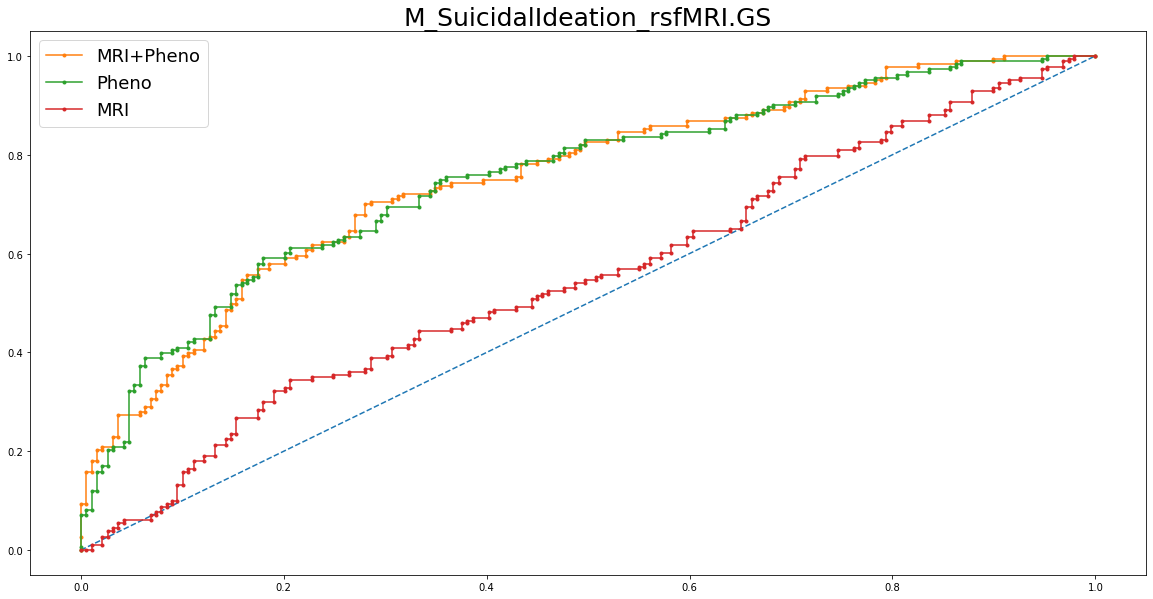

test_auc_pheno+mri =  0.7547344377945471 test_auc_pheno =  0.7540405354613005 test_auc_mri =  0.552866684014225


,feature name,ratio
0,rsfmri_cor_network.gordon_frontoparietal_network.gordon_dorsalattn,0.156686
1,Depress.CBCL,0.082152
2,rsfmri_cor_network.gordon_default_subcort.aseg_thalamus.proper.lh,0.073845
3,AnxDep.CBCL,0.068639
4,Conduct.CBCL,0.066513
5,AnxDisord.CBCL,0.061157
6,poa_total_6month_follow_up,0.060853
7,Internal.and.External.Comobidity,0.046207
8,rsfmri_cor_network.gordon_smmouth_network.gordon_smmouth,0.045442
9,rsfmri_cor_network.gordon_cinguloparietal_subcort.aseg_accumbens.area.lh,0.039341


In [23]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )
    
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    """
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    
    n_ = [4]
    lr_ = [2e-2, 1e-3]
    w_ = [0.01]
    g_ = [0.95]
    ss_ = [10]
     """
    # define hyperparameter space (quick version)
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-3]
    w_ = [0.01, 0.001]
    g_ = [0.95, 0.9]
    ss_ = [10, 20]
   
    
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        print("--------Valid score: {} --------------------".format(-clf.best_cost))
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy
    
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy, features):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    
    
    
    print("Max hy:" ,hy)
    print("--------Valid score: {} --------------------".format(-clf.best_cost))
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf, preds_prob
    
    
def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf, preds_prob = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test
                                               , max_hy, features)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    

    return test_auc, Y_test, clf, preds_prob, import_feat



    
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_every = pd.DataFrame()
    features_all = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 
    features_mri = [ col for col in mri if col not in 'rsfmri_cor_network.gordon_subcort.aseg_visitid']  

    features_pheno = [ col for col in train_data_processed.columns if col not in unused_feat + [target] 
                +mri] 
   
    test_auc_all, Y_test_all, clf, preds_prob_all, import_feat_all = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_all
                                             )
   
    test_auc_pheno, Y_test_pheno, clf, preds_prob_pheno, import_feat_pheno = run(train_data_processed, test_data_processed, 
                                            0, Num_feat, features_pheno)
  

    test_auc_mri, Y_test_mri, clf, preds_prob_mri, import_feat_mri = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_mri)
  
    
    fig , ax = plt.subplots(figsize= (20,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    rocvis(Y_test_all , preds_prob_all[:,1] , "MRI+Pheno")
    rocvis(Y_test_pheno , preds_prob_pheno[:,1] , "Pheno")
    rocvis(Y_test_mri , preds_prob_mri[:,1] , "MRI")
    #rocvis(caty_Test , catprob[:,1] , "CatBoost")
    plt.legend(fontsize = 18)
    plt.title(dataset_name, fontsize= 25)
    plt.show()
    return test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri
    
      

test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri =hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)

print("test_auc_pheno+mri = ", test_auc_all, "test_auc_pheno = ", test_auc_pheno, "test_auc_mri = ", test_auc_mri)

import_feat_every=pd.concat([import_feat_all,import_feat_pheno, import_feat_mri])

import_feat_every 


In [ ]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )
    
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    """
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    """
    # define hyperparameter space (quick version)
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20]
  
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        print("--------Valid score: {} --------------------".format(-clf.best_cost))
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy
    
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy, features):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    
    
    
    print("Max hy:" ,hy)
    print("--------Valid score: {} --------------------".format(-clf.best_cost))
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf, preds_prob
    
    
def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf, preds_prob = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test
                                               , max_hy, features)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    

    return test_auc, Y_test, clf, preds_prob, import_feat



    
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_every = pd.DataFrame()
    features_all = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 
    features_mri = [ col for col in mri if col not in 'rsfmri_cor_network.gordon_subcort.aseg_visitid']  
    features_pheno = [ col for col in train_data_processed.columns if col not in unused_feat + [target] 
                +mri] 
   
    test_auc_all, Y_test_all, clf, preds_prob_all, import_feat_all = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_all
                                             )
   
    test_auc_pheno, Y_test_pheno, clf, preds_prob_pheno, import_feat_pheno = run(train_data_processed, test_data_processed, 
                                            0, Num_feat, features_pheno)
  

    test_auc_mri, Y_test_mri, clf, preds_prob_mri, import_feat_mri = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_mri)
  
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    rocvis(Y_test_all , preds_prob_all[:,1] , "MRI+Pheno")
    rocvis(Y_test_pheno , preds_prob_pheno[:,1] , "Pheno")
    rocvis(Y_test_mri , preds_prob_mri[:,1] , "MRI")
    #rocvis(caty_Test , catprob[:,1] , "CatBoost")
    plt.legend(fontsize = 18)
    plt.title(dataset_name, fontsize= 25)
    plt.show()
    return test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri
    
      

test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri =hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)

print("test_auc_pheno+mri = ", test_auc_all, "test_auc_pheno = ", test_auc_pheno, "test_auc_mri = ", test_auc_mri)

import_feat_every=pd.concat([import_feat_all,import_feat_pheno, import_feat_mri])

import_feat_every 


done preprocessing
---------------------------------------Training Begining for fold 1-------------------------------


Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7525360028552875 --------------------
--------Test auc: 0.7237979587706365 Test acc:0.5080645161290323-------------
Device used : cuda
--------Valid score: 0.7651848411